In [1]:
import torch
import numpy as np
import time

import sys
import os
import time

import jax
import jax.numpy as jnp

path_ = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if path_ not in sys.path:
    sys.path.append(path_)

from non_parametric_collocation import collocate_data
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from neural_net_pytorch import create_train_state_py, train_py, neural_ode_py
import matplotlib.pyplot as plt

In [ ]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.0
ode_type, params = "sinusoidal_oscillator", {"A": 2}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

plt.figure(figsize=(10, 5))
plt.plot(t_test, y_test, 'g--', label='True Solution')
plt.scatter(t, y_noisy.T, label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [2]:
n_points = 200
ode_type = "harmonic_oscillator"
params = {"omega_squared": 2}
start_time=0
end_time=10
spacing_type="equally_spaced"
initial_state = np.array([0.0, 1.0])

In [3]:
y0 = np.array([0.0, 1.0])
layer_widths = [2, 100, 100, 2]
learning_rate = 1e-3

y_pred_results = {}

# 0.0, 0.1, 0.2, 0.5
for i, noise_level in enumerate([0.2]):
    # Generate data for the according noise level
    t, y, y_noisy, true_derivatives = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)
    
    t = np.array(t)
    y_noisy = np.array(y_noisy)
    y_noisy = torch.tensor(y_noisy, dtype=torch.float32)

    model, optimizer = create_train_state_py(layer_widths, learning_rate)
    
    start_timer = time.time()
    trained_model = train_py(model, optimizer, t, y_noisy, y0, num_epochs = 1000)
    end_timer = time.time()
    timer = end_timer - start_timer
    print(f"Time elapsed: {timer}")

    # Generate predictions
    y_pred = neural_ode_py(trained_model, y0, t)
    y_pred_results[str(i)] = {"predictions": y_pred, "time_elapsed": timer, "noise_level": noise_level, "y_noisy": y_noisy.detach().numpy()}

/Users/mariiashapo/anaconda3/envs/collocation_env/lib/python3.9/site-packages/jax/_src/linear_util.py:192: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in linspace is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ans = self.f(*args, **dict(self.params, **kwargs))
/Users/mariiashapo/anaconda3/envs/collocation_env/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3042: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/Users/mariiashapo/anaconda3/envs/collocation_env

Epoch 0, Loss: 3.915067434310913
Epoch 100, Loss: 0.37310564517974854
Epoch 200, Loss: 0.07327194511890411
Epoch 300, Loss: 0.040988337248563766
Epoch 400, Loss: 0.04033434018492699
Epoch 500, Loss: 0.04017641395330429
Epoch 600, Loss: 0.04004460200667381
Epoch 700, Loss: 0.039937328547239304
Epoch 800, Loss: 0.03985360264778137
Epoch 900, Loss: 0.0397905670106411
Time elapsed: 130.06150317192078


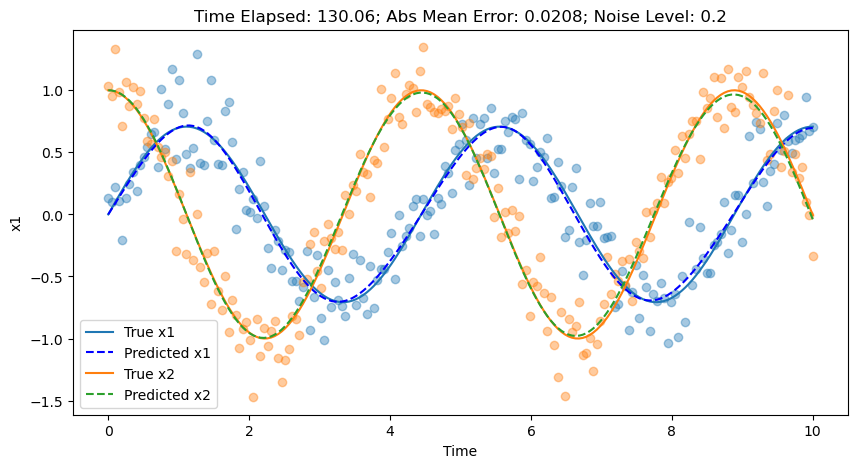

In [4]:
for i in range(len(y_pred_results)):
    result = y_pred_results[str(i)]
    y_pred = np.array(result["predictions"])
    y_noisy = np.array(result["y_noisy"])
    y = np.array(y)
    plt.figure(figsize=(10, 5))
    plt.plot(t, y[:, 0], label='True x1')
    plt.scatter(t, y_noisy[:, 0], alpha = 0.4)
    plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
    plt.plot(t, y[:, 1], label='True x2')
    plt.plot(t, y_pred[:, 1], '--', label='Predicted x2')
    plt.scatter(t, y_noisy[:, 1], alpha = 0.4)
    plt.xlabel('Time')
    plt.ylabel('x1')
    plt.legend()
    mae = np.mean(np.abs(y_pred - y))
    plt.title(f'Time Elapsed: {result["time_elapsed"]:.2f}; Abs Mean Error: {mae:.4f}; Noise Level: {result["noise_level"]}')
    plt.show()